In [360]:
import sqlite3 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib 
import sklearn 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.metrics import root_mean_squared_error

conn = sqlite3.connect(r"/Users/kelvinfoo/Desktop/AISG Technical Assignments/Test Score Prediction/score.db")
score_df = pd.read_sql_query("SELECT * FROM score", conn)
score_df.head()


,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


#### **Types of features in score_df:** 
**1. Numerical**
- Number of siblings 
- Final test score 
- Number of males in the class 
- Number of females in the class 
- Age 
- Hours per week spent studying
- Attendance rate


**2. Categorical**
- Direct admission 
- CCA
- Learning style
- Gender 
- Tuition
- Mode of transport
- Bag color

**3. Time**
- Sleep time 
- Wake time

**4. Identifier**
- Index 
- Student ID


In [361]:
print(f"There are {score_df.shape[0]} rows and there are {score_df['student_id'].nunique()} unique students in score_df.")

There are 15900 rows and there are 15000 unique students in score_df.


Since there are 15900 observations and only 15000 unique students in the record, there are 900 students with duplicate records. One possible reason might be that a student retained for a year and hence, he might have two records in the dataset. 

### **Dealing with Duplicate Records**

In [362]:
# Group records with similar student ID together to determine if records were similar. 
duplicate_student = score_df[score_df.groupby("student_id")["student_id"].transform("size") > 1].sort_values(by = ["student_id"])
duplicate_student.head(20)

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
5534,5534,0,No,Clubs,Auditory,00811H,Female,Yes,88.0,21.0,4.0,15.0,8.0,92.0,23:00,7:00,walk,green
12290,12290,0,No,Clubs,Auditory,00811H,Female,Yes,88.0,21.0,4.0,15.0,8.0,92.0,23:00,7:00,walk,white
12270,12270,1,No,Arts,Visual,0195IO,Female,No,52.0,8.0,22.0,16.0,15.0,99.0,22:00,6:00,private transport,yellow
13541,13541,1,No,Arts,Visual,0195IO,Female,No,52.0,8.0,22.0,16.0,15.0,99.0,22:00,6:00,private transport,yellow
4303,4303,0,No,Clubs,Auditory,02RSAH,Female,Yes,64.0,12.0,9.0,15.0,17.0,97.0,22:00,6:00,private transport,yellow
9172,9172,0,No,Clubs,Auditory,02RSAH,Female,Yes,64.0,12.0,9.0,15.0,17.0,97.0,22:00,6:00,private transport,green
8641,8641,0,No,Arts,Auditory,0FC4RY,Female,No,68.0,23.0,4.0,15.0,6.0,NaN,23:00,7:00,walk,blue
9791,9791,0,No,Arts,Auditory,0FC4RY,Female,No,68.0,23.0,4.0,15.0,6.0,100.0,23:00,7:00,walk,yellow
1405,1405,0,Yes,None,Visual,0JUGAF,Female,No,84.0,18.0,2.0,16.0,10.0,94.0,23:00,7:00,walk,red
6339,6339,0,Yes,None,Visual,0JUGAF,Female,No,84.0,18.0,2.0,16.0,10.0,94.0,23:00,7:00,walk,yellow


- Based on the above sample duplicate records, majority of the students had duplicate records because they had changed bags halfway in their school term and that the bag was of a different color. The other fields remained the same for majority of the duplicate records. 
- There was one student whose attendance rate was null in one record and 100.0 in another record. 

**Considerations:**
- We can determine if bag color is an important factor in modelling student test score. If it is not an important factor, we can drop those duplicate rows where bag color is the only field with different values. 
- For the case where attendance rate was null in one record and 100.0 in another, we can drop the row where attendance rate was null for the student.

In [363]:
# Find number of features in score_df with missing values 
null_features = [feature for feature in score_df.columns 
                 if score_df[feature].isnull().sum() > 1]

print("For the whole dataset:")
for feature in null_features: 
    print(f"{feature} has {score_df[feature].isnull().sum()} missing values (ie. {round(score_df[feature].isnull().sum() / len(score_df) * 100.0,2)}% of dataset).")

For the whole dataset:
final_test has 495 missing values (ie. 3.11% of dataset).
attendance_rate has 778 missing values (ie. 4.89% of dataset).


There are only two features with missing values: final_test and attendance_rate. The number of rows with missing values for each feature accounts for less than 5% of total records.

In [364]:
# Find number of features in duplicate records with missing values 
null_features = [feature for feature in duplicate_student.columns 
                 if duplicate_student[feature].isnull().sum() > 1]

print("For duplicate records:")
for feature in null_features: 
    print(f"{feature} has {duplicate_student[feature].isnull().sum()} missing values.")

For duplicate records:
final_test has 56 missing values.
attendance_rate has 90 missing values.


<Axes: xlabel='bag_color', ylabel='final_test'>

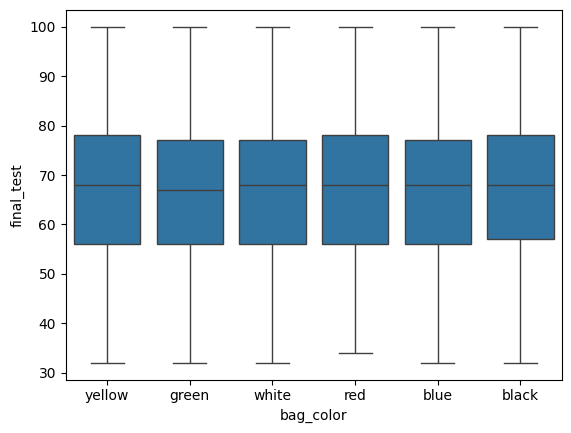

In [365]:
# Determine if bag color influences final test score 
non_duplicates = score_df[~(score_df['student_id'].isin(duplicate_student['student_id']))]
sns.boxplot(x = 'bag_color', y = 'final_test', data = non_duplicates)

- Considering only records where there were no duplicate student IDs, the distribution of final test score is consistent regardless of the bag color of the student. 
- It is safe to assume that bag color is not an important factor in modelling final test score. Hence, we will drop the feature from the dataset. 

In [366]:
# Drop the column for bag color 
score_df_copy = score_df.copy()
score_df_withoutbag = score_df_copy.drop(['bag_color', 'index'], axis = 1)

# Find number of duplicate rows 
print(f"After dropping the column for bag color, there are {score_df_withoutbag.duplicated().sum()} duplicate records in the dataset.")

# Drop duplicate rows 
score_df_withoutbag = score_df_withoutbag.drop_duplicates()
print(f"After dropping the duplicate rows, we have {score_df_withoutbag.shape[0]} rows.")

After dropping the column for bag color, there are 765 duplicate records in the dataset.
After dropping the duplicate rows, we have 15135 rows.


In [367]:
duplicate_student = score_df_withoutbag[score_df_withoutbag.groupby("student_id")["student_id"].transform("size") > 1].sort_values(by = ["student_id"])
duplicate_student.head(30)

,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport
8641,0,No,Arts,Auditory,0FC4RY,Female,No,68.0,23.0,4.0,15.0,6.0,NaN,23:00,7:00,walk
9791,0,No,Arts,Auditory,0FC4RY,Female,No,68.0,23.0,4.0,15.0,6.0,100.0,23:00,7:00,walk
11598,0,No,Clubs,Auditory,0VTYP7,Male,Yes,94.0,16.0,5.0,15.0,7.0,99.0,21:30,5:30,public transport
12166,0,No,Clubs,Auditory,0VTYP7,Male,Yes,94.0,16.0,5.0,15.0,7.0,NaN,21:30,5:30,public transport
8240,2,No,Sports,Visual,11RQTT,Male,No,71.0,22.0,0.0,15.0,16.0,NaN,21:00,5:00,public transport
9683,2,No,Sports,Visual,11RQTT,Male,No,71.0,22.0,0.0,15.0,16.0,98.0,21:00,5:00,public transport
2763,0,No,Clubs,Visual,11V0BQ,Female,No,NaN,24.0,0.0,16.0,10.0,98.0,23:00,7:00,walk
12347,0,No,Clubs,Visual,11V0BQ,Female,No,79.0,24.0,0.0,16.0,10.0,98.0,23:00,7:00,walk
5988,1,Yes,None,Visual,1ICS4I,Male,Yes,91.0,14.0,7.0,16.0,10.0,NaN,21:30,5:30,public transport
13626,1,Yes,None,Visual,1ICS4I,Male,Yes,91.0,14.0,7.0,16.0,10.0,95.0,21:30,5:30,public transport


- After removing duplicate rows, from the sample records above, majority of the duplicate student IDs were due to one record having null value for either attendance rate or final test score or both and the other record having the actual value for the corresponding field. 
- We can drop rows where either attendance rate or final test score or both is empty. 

- After droping rows with null values for either attendance rate or final test score from duplicate_student, there exist no more duplicate student IDs in the dataset. 
- The final dataset (containing no duplicate student IDs) has 13885 observations.

In [368]:
new_score = score_df_withoutbag.dropna(subset = ['attendance_rate', 'final_test'], how = 'any')
duplicate_student = new_score[new_score.groupby("student_id")["student_id"].transform("size") > 1].sort_values(by = ["student_id"])
duplicate_student.head()

,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport


In [369]:
new_score = new_score.drop_duplicates()
print(f"There are {new_score.shape[0]} rows in new_score_df.")

There are 13885 rows in new_score_df.


### **Dealing with Missing Values**
After the removal of duplicate student IDs and rows, there exists no more features with missing values.

In [370]:
null_features = [feature for feature in new_score.columns 
                 if new_score[feature].isnull().sum() > 1]

print("For the whole dataset:")
if len(null_features) > 0: 
    for feature in null_features: 
        print(f"{feature} has {new_score[feature].isnull().sum()} missing values (ie. {round(new_score[feature].isnull().sum() / len(new_score) * 100.0,2)}% of dataset).")
else: 
    print("There are no null features.")

For the whole dataset:
There are no null features.


In [371]:
new_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13885 entries, 0 to 15899
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   number_of_siblings  13885 non-null  int64  
 1   direct_admission    13885 non-null  object 
 2   CCA                 13885 non-null  object 
 3   learning_style      13885 non-null  object 
 4   student_id          13885 non-null  object 
 5   gender              13885 non-null  object 
 6   tuition             13885 non-null  object 
 7   final_test          13885 non-null  float64
 8   n_male              13885 non-null  float64
 9   n_female            13885 non-null  float64
 10  age                 13885 non-null  float64
 11  hours_per_week      13885 non-null  float64
 12  attendance_rate     13885 non-null  float64
 13  sleep_time          13885 non-null  object 
 14  wake_time           13885 non-null  object 
 15  mode_of_transport   13885 non-null  object 
dtypes: float6

## **Exploratory Data Analysis**

### **Numerical Features**
- Number of siblings 
- Number of male students in the class
- Number of female students in the class
- Age 
- Hours spent studying per week 
- Attendance rate

<Axes: xlabel='final_test', ylabel='Count'>

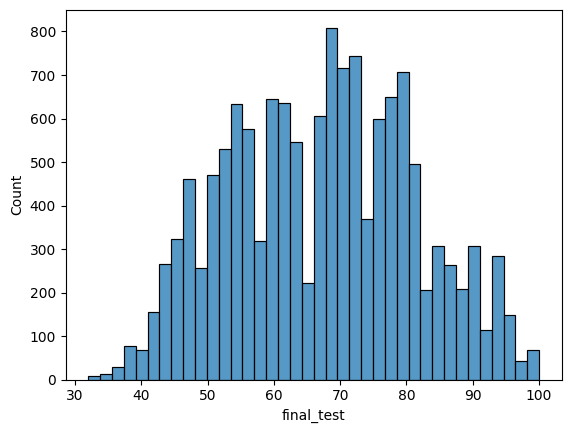

In [372]:
sns.histplot(x = 'final_test', data = new_score)

- Final test score was left-skewed and majority of the students scored close to the 70 mark range. 

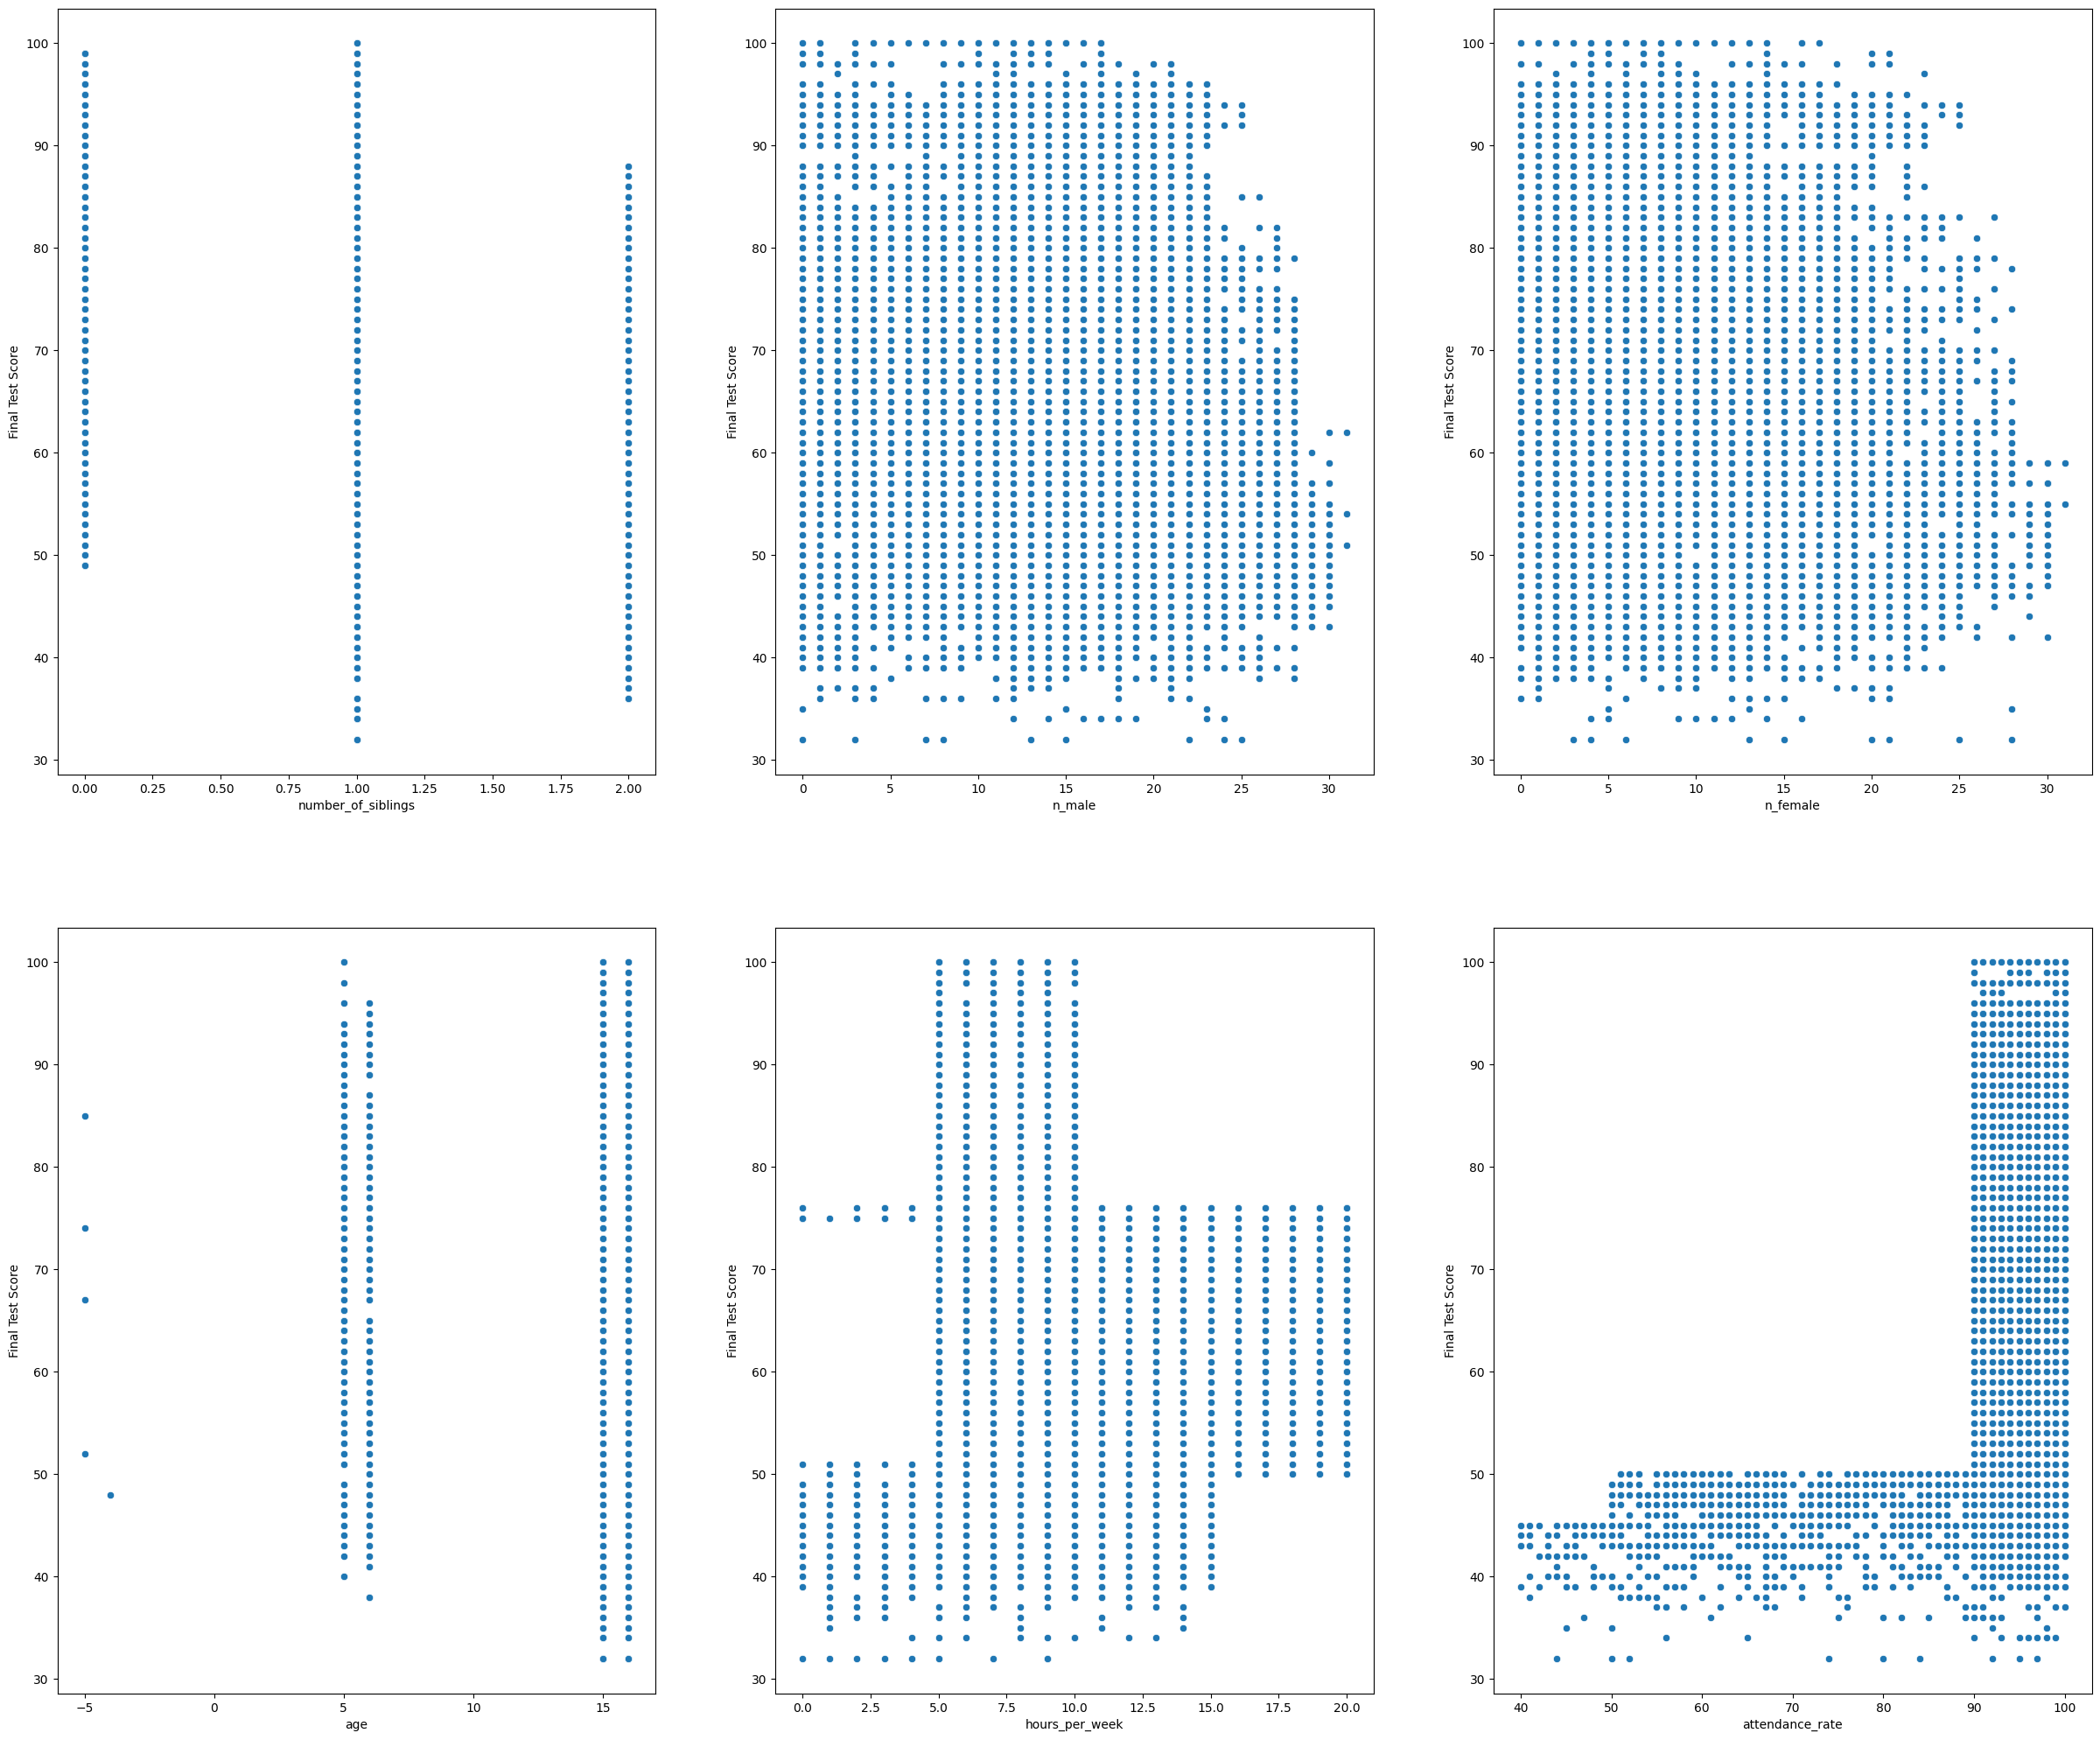

In [373]:
numerical = ['number_of_siblings', 'n_male', 'n_female', 'age', 'hours_per_week', 'attendance_rate']

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (30, 25))
for i, feature in enumerate(numerical, 1): 
    plt.subplot(2, 3, i)
    sns.scatterplot(x = feature, y = 'final_test', data = new_score)
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Final Test Score')

- Number of male and female students in the class had no impact on the distribution of final test score. However, when there is a large number of male and female students in the class, students tend to have lower final test score. 
- Students who performed the best studied between 5 to 10 hours per week. Students who studied less than 5 hours per week got 50 and lower mostly while students who studied more than 10 hours could not get beyond 80 marks. 
- Students who had an attendance rate of less than 90 could only get less than 60 marks. 
- There seem to be anomalies in thr age. Children at the age of 5 are unlikely to have O-level examinations. Also, there are a few wrong entries of negative age.

In [374]:
new_score['age'] = new_score['age'].astype(float)
new_score['age'] = new_score['age'].apply(lambda x: int('1' + str(int(abs(x)))) if x < 10 else int(x))

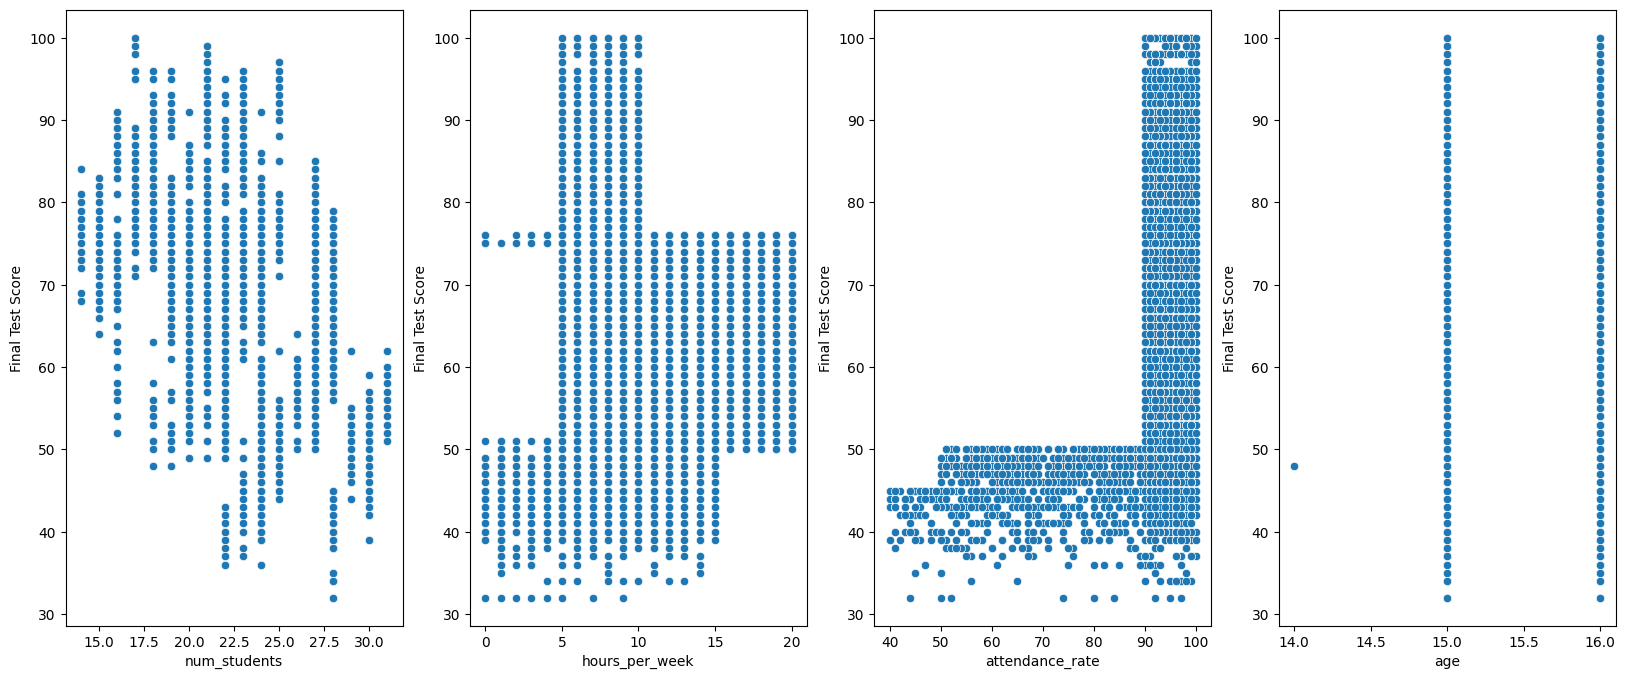

In [375]:
new_score['num_students'] = new_score['n_male'] + new_score['n_female']

numerical = ['num_students', 'hours_per_week', 'attendance_rate', 'age']
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (20, 8))
for i, feature in enumerate(numerical, 1): 
    plt.subplot(1, 4, i)
    sns.scatterplot(x = feature, y = 'final_test', data = new_score)
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Final Test Score')


- Students in classes with more than 28 students tend to score a maximum of below 70 marks.

### **Categorical Features**
- Number of siblings
- Direct admission 
- CCA
- Learning style
- Gender 
- Tuition
- Mode of transport

In [376]:
new_score['number_of_siblings'] = new_score['number_of_siblings'].astype('str')
new_score['attendance_status'] = new_score['attendance_rate'].apply(lambda x: 'High' if x >= 90 else 'Low')

categorical = ['number_of_siblings', 'direct_admission', 'CCA', 'learning_style', 'gender', 'tuition', 'mode_of_transport', 'attendance_status']
for feature in categorical: 
    print(new_score[feature].value_counts())
    print('\n')

number_of_siblings
1    5866
0    4780
2    3239
Name: count, dtype: int64


direct_admission
No     9832
Yes    4053
Name: count, dtype: int64


CCA
Clubs     3421
Sports    3376
None      3321
Arts      3314
CLUBS      127
ARTS       114
NONE       114
SPORTS      98
Name: count, dtype: int64


learning_style
Auditory    8012
Visual      5873
Name: count, dtype: int64


gender
Male      6950
Female    6935
Name: count, dtype: int64


tuition
Yes    7583
No     5788
Y       287
N       227
Name: count, dtype: int64


mode_of_transport
public transport     5548
private transport    5542
walk                 2795
Name: count, dtype: int64


attendance_status
High    13002
Low       883
Name: count, dtype: int64




There are some features with having multiple labels with the same meaning. For example, 
- CCA: Clubs and CLUBS, Arts and ARTS, None and NONE, Sports and SPORTS. 
- Tuition: Yes and Y, No and N.

In [377]:
CCA_mapping = {'CLUBS': 'Clubs', 'ARTS': 'Arts', 'SPORTS': 'Sports', 'NONE': 'None'}
tuition_mapping = {'Y': 'Yes', 'N': 'No'}

new_score = new_score.replace({"CCA": CCA_mapping})
new_score = new_score.replace({"tuition": tuition_mapping})

categorical = ['number_of_siblings', 'direct_admission', 'CCA', 'learning_style', 'gender', 'tuition', 'mode_of_transport', 'attendance_status']
for feature in categorical: 
    print(new_score[feature].value_counts())
    print('\n')

number_of_siblings
1    5866
0    4780
2    3239
Name: count, dtype: int64


direct_admission
No     9832
Yes    4053
Name: count, dtype: int64


CCA
Clubs     3548
Sports    3474
None      3435
Arts      3428
Name: count, dtype: int64


learning_style
Auditory    8012
Visual      5873
Name: count, dtype: int64


gender
Male      6950
Female    6935
Name: count, dtype: int64


tuition
Yes    7870
No     6015
Name: count, dtype: int64


mode_of_transport
public transport     5548
private transport    5542
walk                 2795
Name: count, dtype: int64


attendance_status
High    13002
Low       883
Name: count, dtype: int64




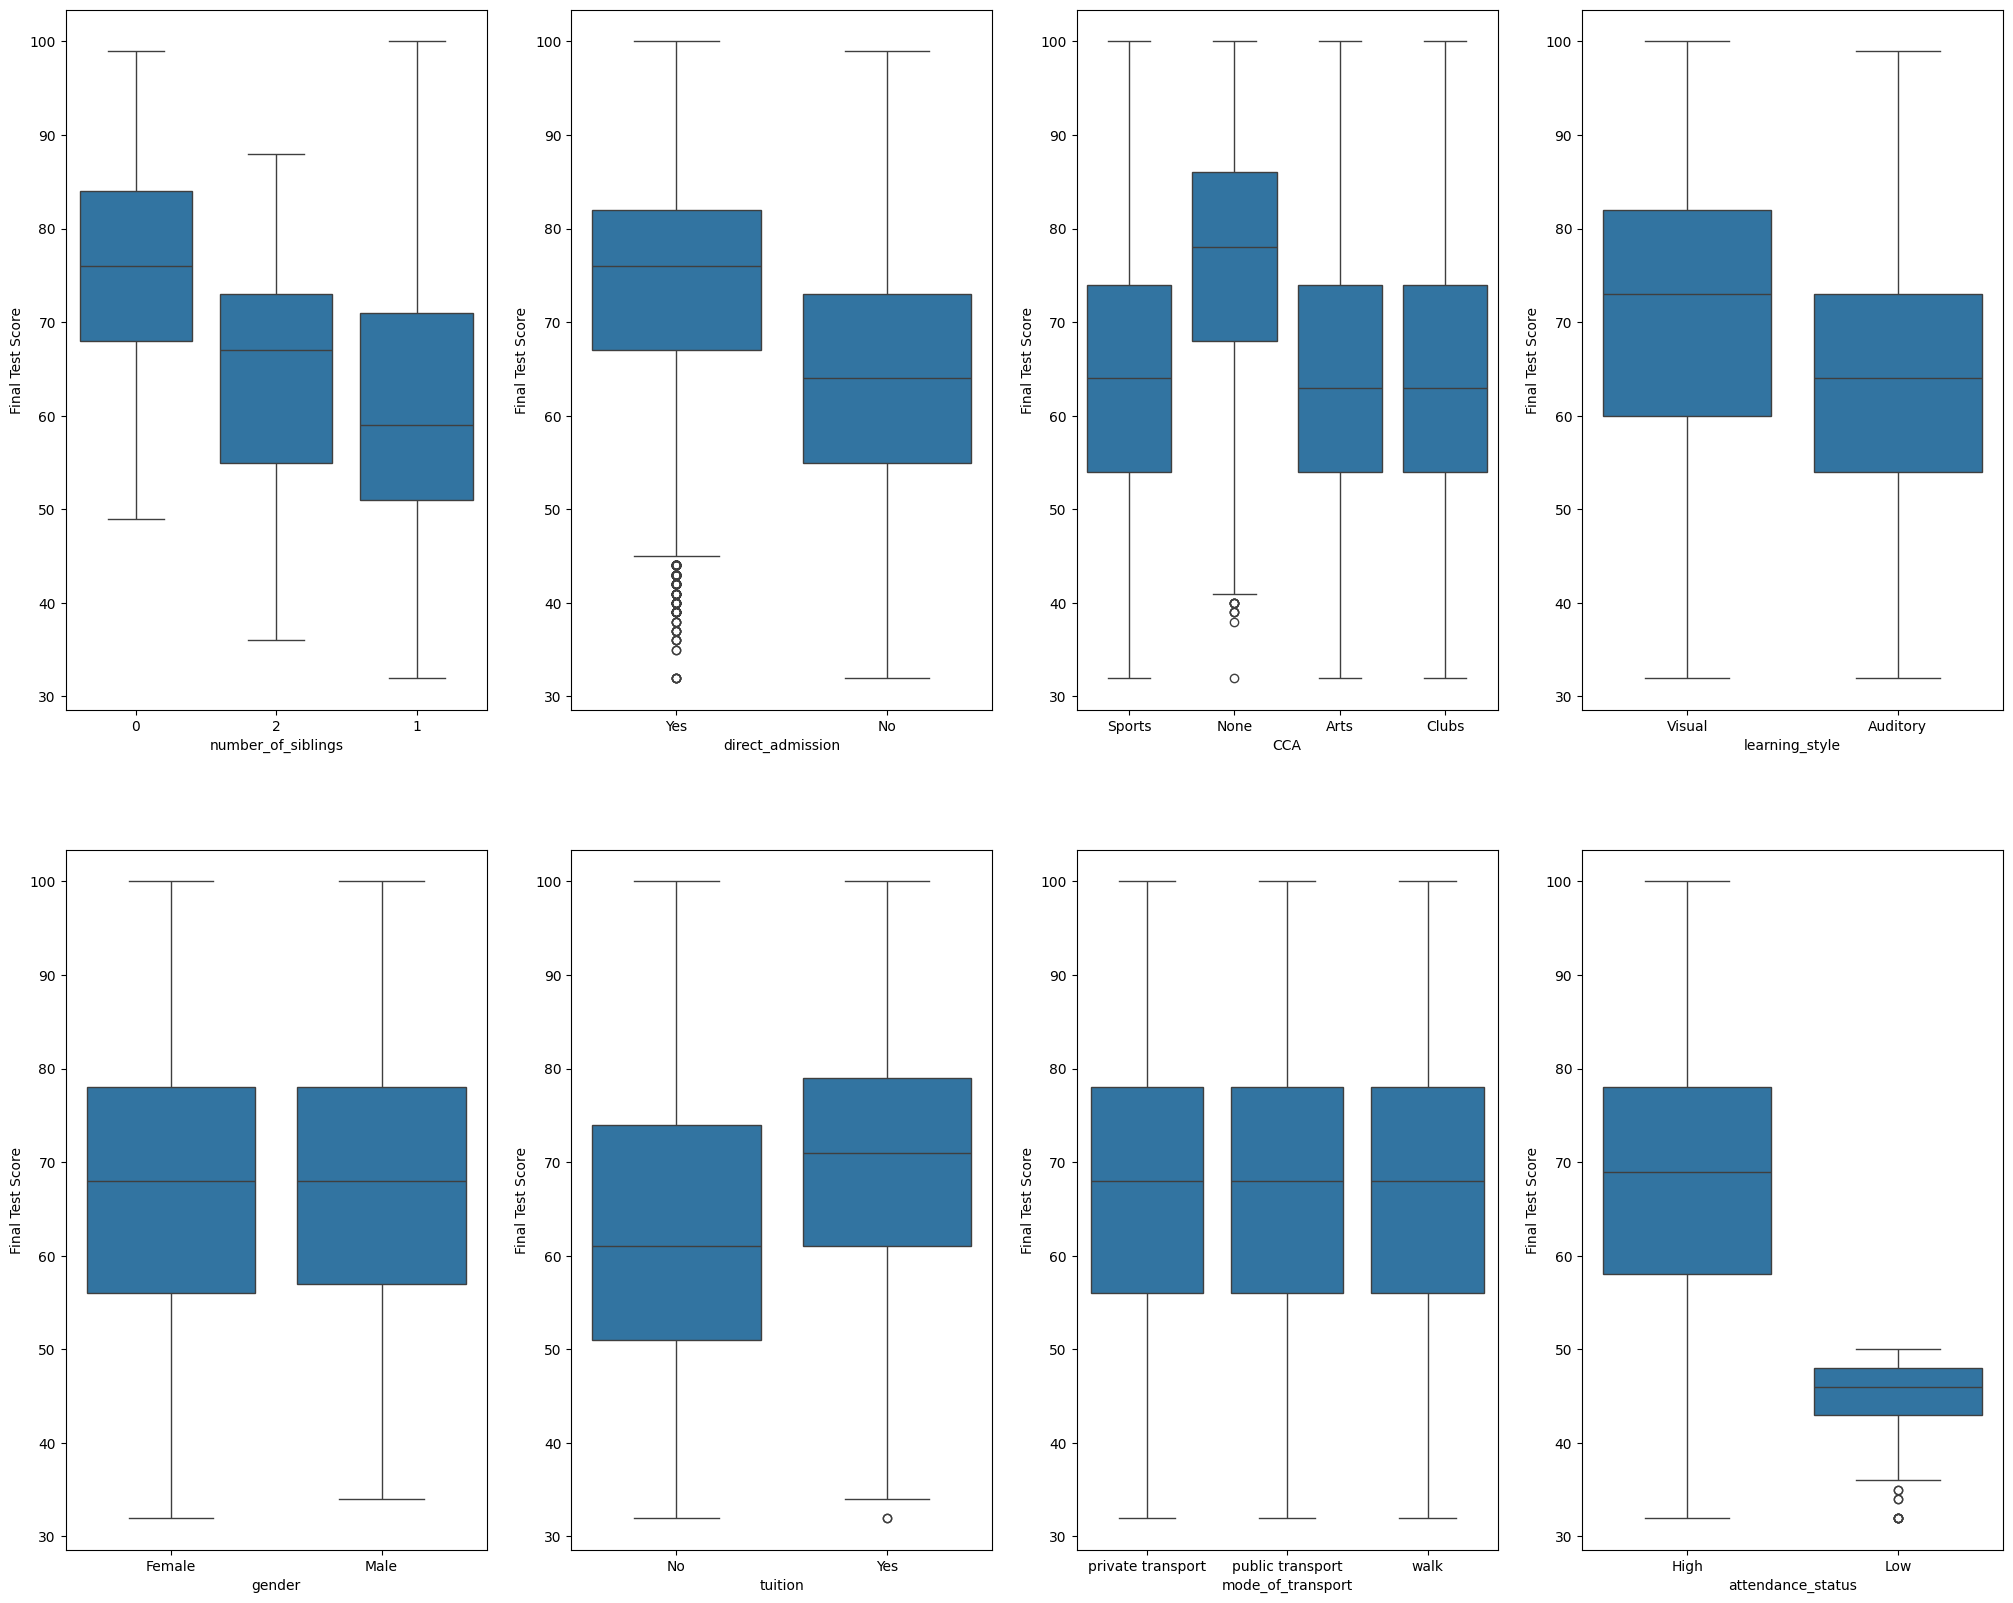

In [378]:
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (25, 20))

for i, feature in enumerate(categorical, 1): 
    plt.subplot(2, 4, i)
    sns.boxplot(x = feature, y = 'final_test', data = new_score)

    plt.xlabel('{}'.format(feature))
    plt.ylabel('Final Test Score')

- Students who had no siblings had a higher median final test score than students who had siblings. Students who had 2 siblings had a higher median final test score and a lower variability in final test score compared to student with only 1 sibling.
- Students who were admitted to the school via direct admission had a higher median final test score compared to those who were not admitted by direct admission. 
- Students who had no CCA had a higher median final test score than those who were had either clubs, sports or arts CCA. Students in sports CCA had a slightly higher median final test score than those in clubs and arts. Students in clubs and arts had similar median final test score. 
- Students who were visual learners had a higher median final test score than auditory learners. 
- Male and female students had relatively similar median final test score although the variability in final test score was larger for female students. 
- Students who had tuition had a higher median final test score. 
- Median final test score were relatively constant across different modes of transports. 
- Students with low attendance rate (Less than 90) had a much lower final test score in general than students with attendance rate of 90 and higher.

**Impact on modelling**
- The more influential categorical features on modelling final test score were number of siblings, direct admission, type of CCA, learning style and whether they had tuition. 

### **Time Features**

In [379]:
time = ['sleep_time', 'wake_time']
for feature in time: 
    print(new_score[feature].value_counts())
    print("\n")

sleep_time
23:00    2732
22:00    2686
22:30    2654
21:00    2569
21:30    2510
0:00      213
23:30     162
1:00      105
0:30       77
2:00       72
1:30       62
2:30       23
3:00       20
Name: count, dtype: int64


wake_time
5:00    2819
7:00    2795
6:00    2783
6:30    2759
5:30    2729
Name: count, dtype: int64




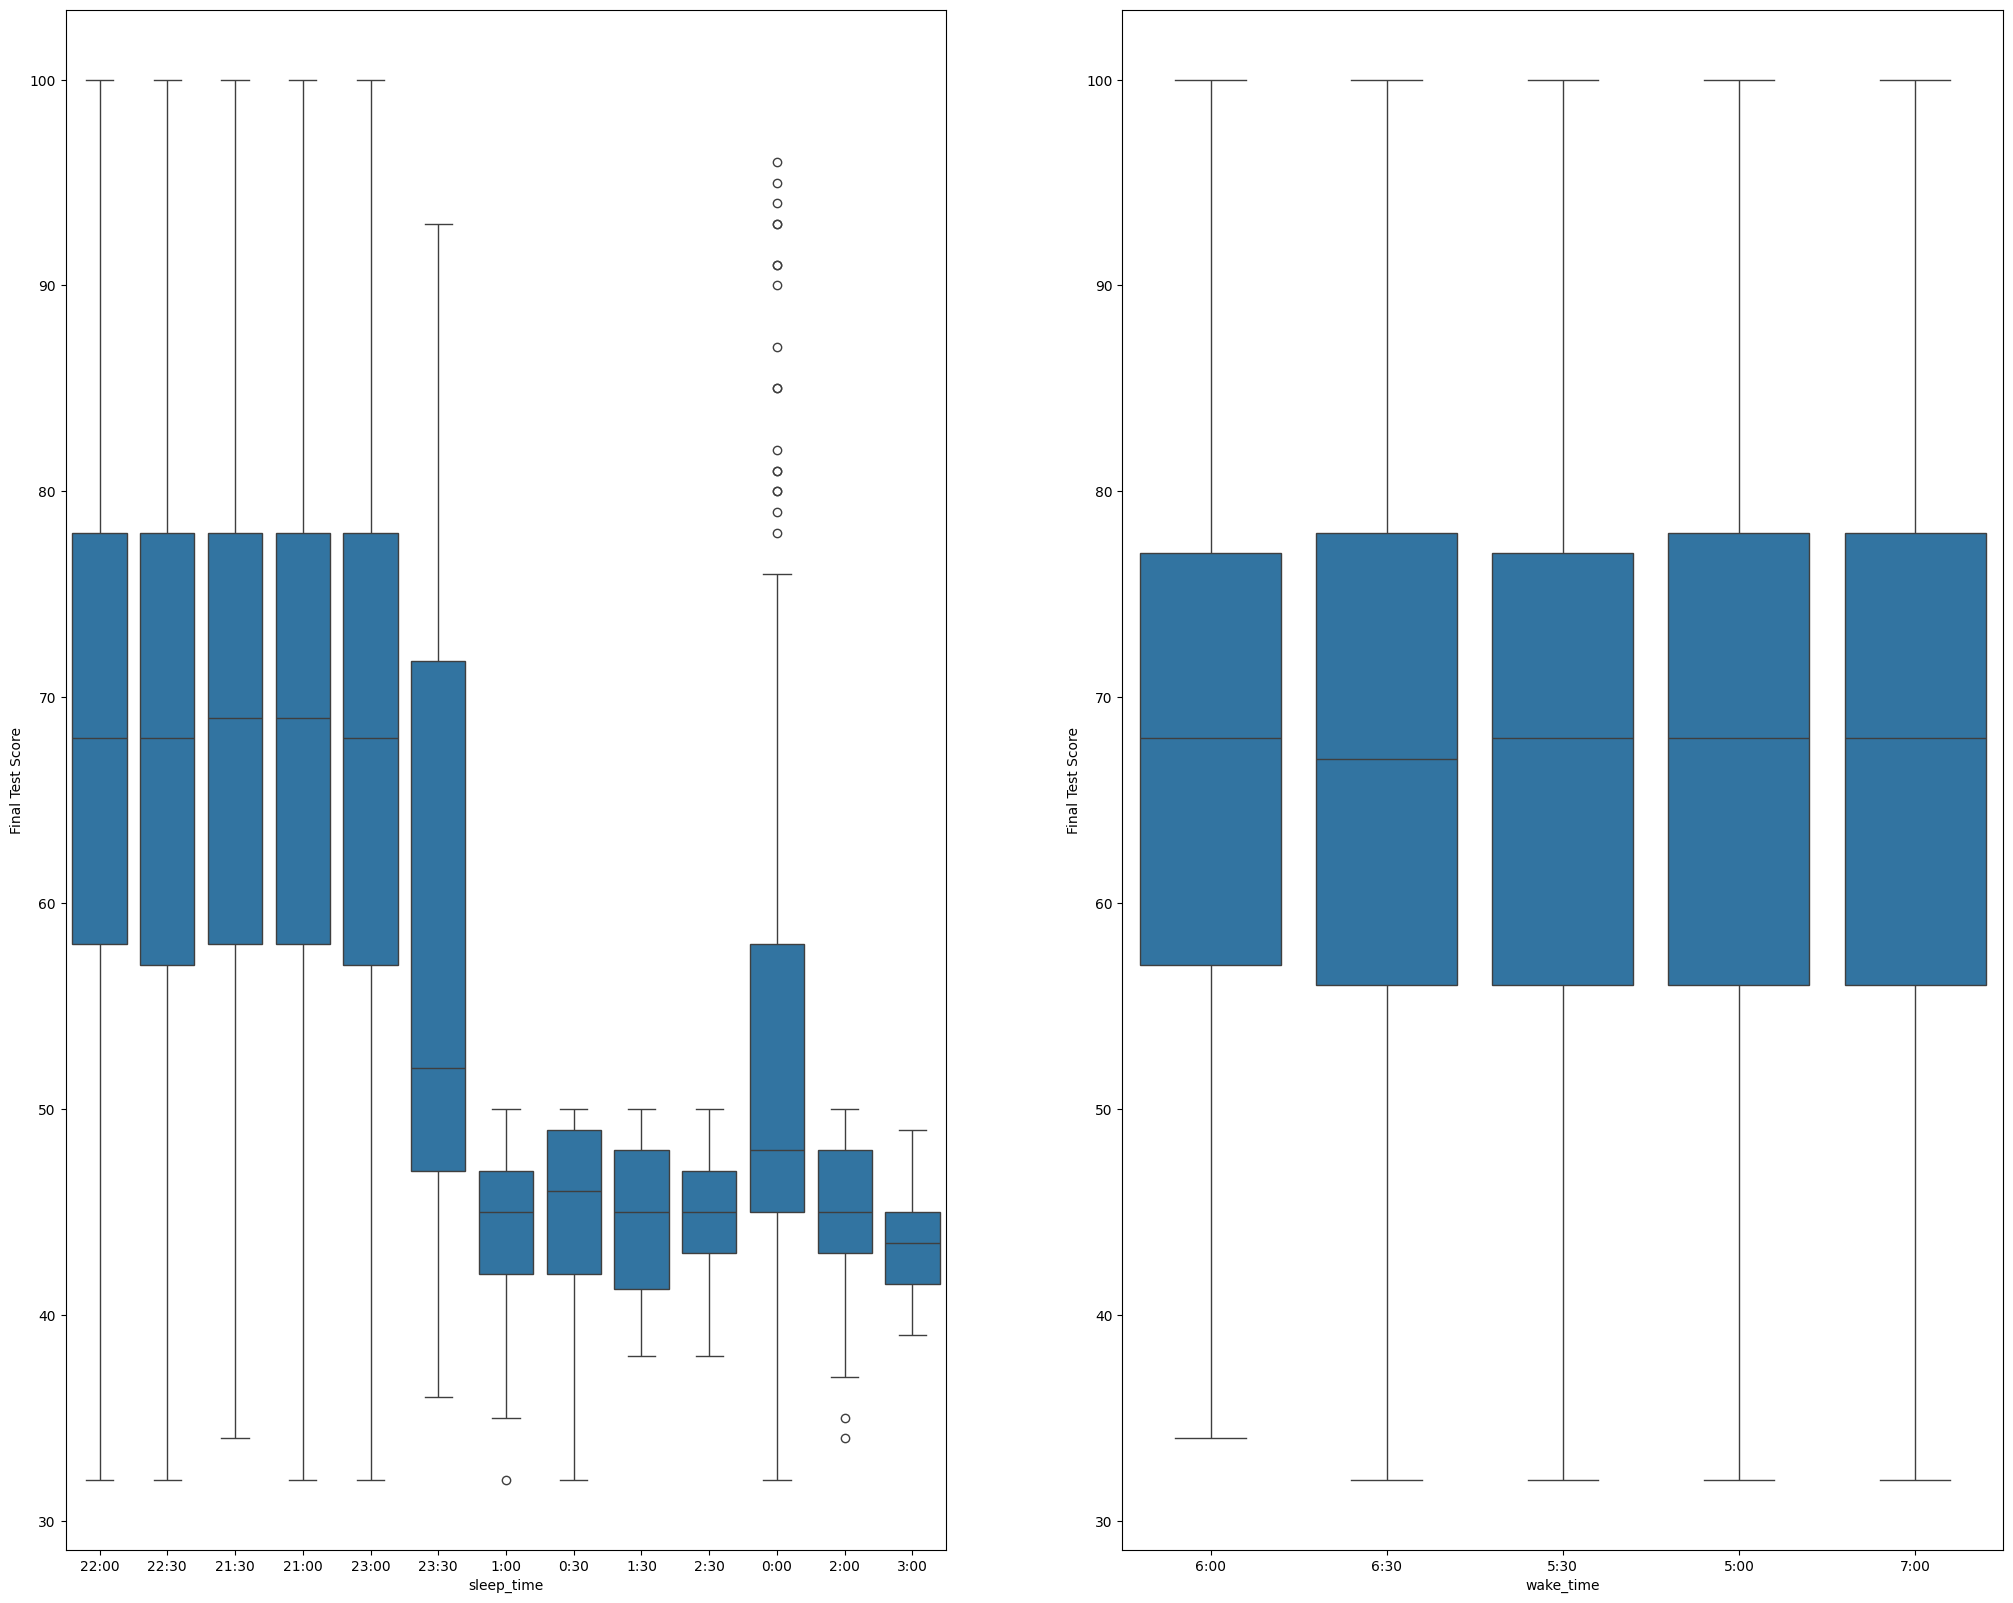

In [380]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (25, 20))

for i, feature in enumerate(time, 1): 
    plt.subplot(1, 2, i)
    sns.boxplot(x = feature, y = 'final_test', data = new_score)

    plt.xlabel('{}'.format(feature))
    plt.ylabel('Final Test Score')

- Students who slept at 11.30pm and later scored lower in general compared to those who slept before 11.30pm. 
- Wake time seem to have little influence on final test score.

In [381]:
new_score['sleep_time_status'] = new_score['sleep_time'].apply(lambda x: 'Before 11.30pm' if x in ['22:00', '22:30', '21:00', '21:30', '23:00'] else '11:30pm and later')

time = ['sleep_time_status']
for feature in time: 
    print(new_score[feature].value_counts())

sleep_time_status
Before 11.30pm       13151
11:30pm and later      734
Name: count, dtype: int64


<Axes: xlabel='sleep_time_status', ylabel='final_test'>

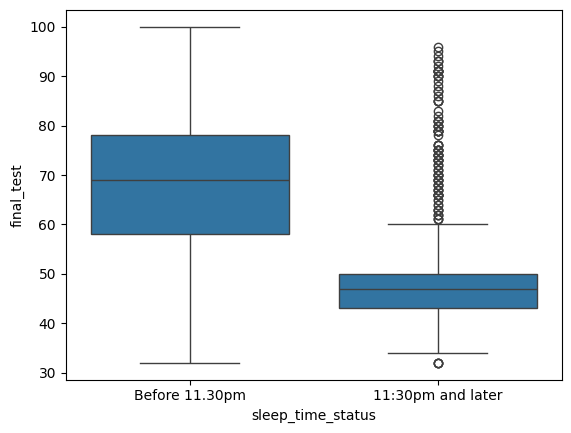

In [382]:
sns.boxplot(x = 'sleep_time_status', y = 'final_test', data = new_score)

<Axes: xlabel='hours_sleep', ylabel='Count'>

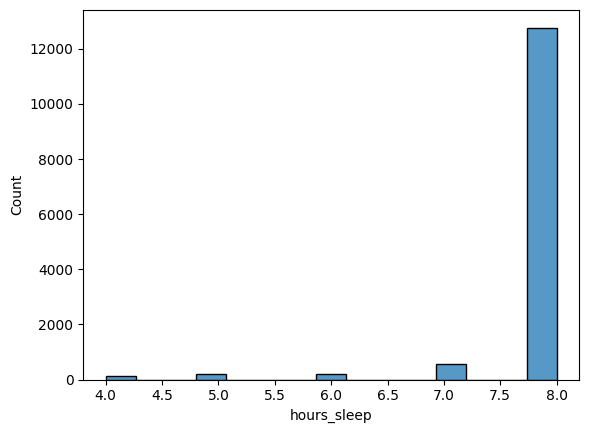

In [383]:
new_score['sleep_time'] = pd.to_datetime(new_score['sleep_time'], format='mixed') 
new_score['wake_time'] = pd.to_datetime(new_score['wake_time'], format='mixed') 
new_score['hours_sleep'] = new_score.apply(lambda row: (row['wake_time'] - row['sleep_time']).total_seconds() / 3600 if row['wake_time'] > row['sleep_time'] else ((row['wake_time'] + pd.Timedelta(days=1)) - row['sleep_time']).total_seconds() / 3600, axis=1)

sns.histplot(x = 'hours_sleep', data = new_score)

<Axes: xlabel='hours_sleep', ylabel='final_test'>

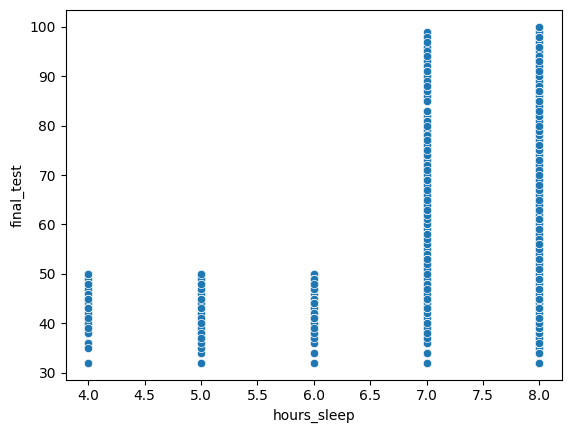

In [384]:
sns.scatterplot(x = 'hours_sleep', y = 'final_test', data = new_score)

- Most students slept close to 8 hours.
- Students who slept 6 hours and lesser had lower final test score in general. 

In [385]:
new_score['sleep_hour_status'] = new_score['hours_sleep'].apply(lambda x: '6 and below' if x <= 6.0 else 'Above 6')

In [386]:
new_score.head()

,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,...,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,num_students,attendance_status,sleep_time_status,hours_sleep,sleep_hour_status
0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,...,10.0,91.0,2024-06-24 22:00:00,2024-06-24 06:00:00,private transport,16.0,High,Before 11.30pm,8.0,Above 6
1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,...,7.0,94.0,2024-06-24 22:30:00,2024-06-24 06:30:00,private transport,23.0,High,Before 11.30pm,8.0,Above 6
2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,...,8.0,92.0,2024-06-24 22:30:00,2024-06-24 06:30:00,private transport,16.0,High,Before 11.30pm,8.0,Above 6
4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,...,7.0,95.0,2024-06-24 21:30:00,2024-06-24 05:30:00,public transport,27.0,High,Before 11.30pm,8.0,Above 6
5,0,No,Arts,Visual,BA6R14,Female,No,57.0,9.0,12.0,...,11.0,96.0,2024-06-24 22:30:00,2024-06-24 06:30:00,private transport,21.0,High,Before 11.30pm,8.0,Above 6


In [387]:
new_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13885 entries, 0 to 15899
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   number_of_siblings  13885 non-null  object        
 1   direct_admission    13885 non-null  object        
 2   CCA                 13885 non-null  object        
 3   learning_style      13885 non-null  object        
 4   student_id          13885 non-null  object        
 5   gender              13885 non-null  object        
 6   tuition             13885 non-null  object        
 7   final_test          13885 non-null  float64       
 8   n_male              13885 non-null  float64       
 9   n_female            13885 non-null  float64       
 10  age                 13885 non-null  int64         
 11  hours_per_week      13885 non-null  float64       
 12  attendance_rate     13885 non-null  float64       
 13  sleep_time          13885 non-null  datetime64[ns]


### **Data Pre-processing**
- Features concerning gender and mode of transport were removed. 
- One hot encoding were applied to categorical features and standard scaling was applied to numerical features in both dataset, after splitting the data into train and test sets. 

In [388]:
new_score_copy = new_score.copy()
new_score_totstudent_sleephours_encoded = new_score_copy[['direct_admission', 'CCA', 'number_of_siblings', 'learning_style', 'tuition', 'final_test', 'num_students', 'age', 
                                                   'hours_per_week', 'attendance_status', 'sleep_time_status', 'sleep_hour_status']]



X_modified = new_score_totstudent_sleephours_encoded.drop(['final_test'], axis = 1)
y_modified = new_score_totstudent_sleephours_encoded['final_test']

In [389]:
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(X_modified, y_modified, test_size = 0.2, random_state = 42)

In [390]:
categorical = ['direct_admission', 'number_of_siblings', 'CCA', 'learning_style', 'tuition', 'attendance_status', 'sleep_time_status', 'sleep_hour_status']
encoder_dict = {}

X_train_encoded_modi = X_train_modified.copy()
X_test_encoded_modi = X_test_modified.copy()

for feature in categorical: 
    encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output= False)
    encoder.fit(X_train_encoded_modi[[feature]])
    encoder_dict[feature] = encoder

    encoded_train= encoder.transform(X_train_encoded_modi[[feature]])
    encoded_test = encoder.transform(X_test_encoded_modi[[feature]])
    encoded_feature_names = encoder.get_feature_names_out([feature])

    encoded_train_df = pd.DataFrame(encoded_train, columns = encoded_feature_names, index = X_train_encoded_modi.index)
    encoded_test_df = pd.DataFrame(encoded_test, columns = encoded_feature_names, index = X_test_encoded_modi.index)

    X_train_encoded_modi = X_train_encoded_modi.drop(columns = [feature])
    X_test_encoded_modi = X_test_encoded_modi.drop(columns = [feature])

    X_train_encoded_modi = pd.concat([X_train_encoded_modi, encoded_train_df], axis = 1)
    X_test_encoded_modi = pd.concat([X_test_encoded_modi, encoded_test_df], axis = 1)

In [391]:
scaler = StandardScaler()
scaler.fit(X_train_encoded_modi)

X_train_scaled = scaler.transform(X_train_encoded_modi)
X_test_scaled = scaler.transform(X_test_encoded_modi)
X_train_scaled_modi = pd.DataFrame(X_train_scaled, columns=X_train_encoded_modi.columns, index=X_train_encoded_modi.index)
X_test_scaled_modi = pd.DataFrame(X_test_scaled, columns=X_test_encoded_modi.columns, index=X_test_encoded_modi.index)

### **Machine Learning**
- Algorithms: Linear regression, random forest regressor and XGBoost. 
- Metrics: Root mean squared error (RMSE)

#### **Linear Regression**

In [392]:
lr2 = LinearRegression()
lr2.fit(X_train_scaled_modi, y_train_modified)
y_pred = lr2.predict(X_test_scaled_modi)
accuracy = root_mean_squared_error(y_pred, y_test_modified)
print(f"The linear regression model has a root mean squared error of: ", round(accuracy, 2))

The linear regression model has a root mean squared error of:  8.85


#### **Random Forest Regressor**

In [393]:
rf2 = RandomForestRegressor(n_estimators = 50, 
                            max_depth = 10, 
                            min_samples_split = 5)

rf2.fit(X_train_scaled_modi, y_train_modified) 
y_pred = rf2.predict(X_test_scaled_modi)
accuracy = root_mean_squared_error(y_pred, y_test_modified)
print(f"The random forest regression (untuned) model has a root mean squared error of: ", round(accuracy, 2))

The random forest regression (untuned) model has a root mean squared error of:  5.26


#### **XGBoost Regressor**

In [394]:
xg2 = xg.XGBRegressor(objective = 'reg:squarederror', n_estimators = 14, max_depth = 8, eval_metric = 'rmse')
xg2.fit(X_train_scaled_modi, y_train_modified) 
y_pred = xg2.predict(X_test_scaled_modi)
accuracy = root_mean_squared_error(y_pred, y_test_modified)
print(f"The XGBoost regression (untuned) model has a root mean squared error of: ", round(accuracy, 2))

The XGBoost regression (untuned) model has a root mean squared error of:  5.25


In [395]:
param_grid = {
    'n_estimators': np.arange(10,20, 1),
    'max_depth': np.arange(5, 15, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
    'gamma': np.arange(0, 5, 0.5),
    'colsample_bytree': np.arange(0.5, 1, 0.1)
    }

grid_search = RandomizedSearchCV(estimator=xg.XGBRegressor(), param_distributions=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled_modi, y_train_modified)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_xg1 = grid_search.best_estimator_
best_xg1.fit(X_train_scaled_modi, y_train_modified)

y_pred = best_xg1.predict(X_test_scaled_modi)
accuracy = root_mean_squared_error(y_pred, y_test_modified)
print(f"The tuned XGBoost regression model has a root mean squared error of: ", round(accuracy, 2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The tuned XGBoost regression model has a root mean squared error of:  5.71


### **Conclusion**
- Without prior tuning, XGBoost regressor performed the best and gave the lowest root mean squared error (5.25). Tuning did not improve the performance of the XGBoost model. 